<a href="https://colab.research.google.com/github/vaibhav-mohanty/RoBound-Calculator/blob/main/RoBound_Calculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RoBound Calculator v1.0

Open-source and easily usable code for calculation of bounds on the robustness of neutral sets in genotype-phenotype maps. Please see the bottom for further information, and visit the GitHub page (https://github.com/vaibhav-mohanty/RoBound-Calculator) for updates.

Please cite **Mohanty V, Greenbury SF, Sarkany T, Narayanan S, Ahnert SE, and Louis AA. Maximally Robust Neutral Sets in Genotype-Phenotype Maps. 2023.**

Contact Vaibhav Mohanty (mohanty@hms.harvard.edu) / Ard A. Louis (ard.louis@physics.ox.ac.uk) with questions and comments. Please report bugs at https://github.com/vaibhav-mohanty/RoBound-Calculator/issues.

In [1]:
#@title Choose input parameters, then click `Runtime` -> `Run all` in the top menu, or run each block in succession. 

#@markdown $L$ = sequence length, $K$ = alphabet size, and `resolution` modulates the number of plot points in the continuous interpolation of the maximum robustness curve (the "blancmange-like curve").

#@markdown For large $L$, large $K$, or high `resolution`, this block may take a long time.

L = 6 #@param {type: number};
K = 2 #@param {type: number};
resolution = 10 #@param {type:"slider", min:1, max:30, step:1}
#@markdown - The number of interpolation points $P$ per unit interval of $\log_K(\text{frequency})$ is given by $P = K^{resolution + 1} - K^{resolution}$. We recommend adjusting $K$ and `resolution` such that $P < 10^5$ for faster performance.

exact_bricklayers = True #@param {type:"boolean"}
#@markdown - Generating the exact bricklayer's graph robustness points (as opposed to only the continuous interpolation) can be extremely time- and memory-intensive and may cause the session RAM to be exceeded, terminating the session. Uncheck the `exact_bricklayers` box to only generate the continuous interpolation.

In [2]:
#@title Run calculations.

import numpy as np
import matplotlib.pyplot as plt

# Exact bricklayer's graphs 

if exact_bricklayers:
    F = np.arange(K**L) + 1
    Sk = np.zeros((K**L))
    Sk[0] = 0
    for i in np.arange(1,K**L):
        temp = [*np.base_repr(i,base=K)]
        Sk[i] = Sk[i-1] + np.sum([int(j) for j in temp])
    logF_all = np.log(F)/np.log(K)
    rhobg_all = 2*np.divide(Sk,F)/(L*(K-1))
    logF_all -= L


# Interploated blancmange-like curve
startL = resolution
F_period = np.arange(K**startL,K**(startL+1))
bg_period = np.zeros((F_period.size))
bg_period[0] = (K**startL)*startL*(K-1)/2
for i in np.arange(1,bg_period.size):
    temp = [*np.base_repr(F_period[i]-1,base=K)]
    bg_period[i] = bg_period[i-1] + np.sum([int(j) for j in temp])

logF_period1 = np.log(F_period)/np.log(K) - startL
bg_rho1 = 2*np.divide(bg_period,F_period)/(L*(K-1)) - startL/L

logF_periodic_all = np.zeros((logF_period1.size*(L)))
bg_rho_periodic_all = np.zeros((bg_rho1.size*(L)))
for i in np.arange(L):
    logF_periodic_all[i*(logF_period1.size):(i+1)*(logF_period1.size)] = logF_period1 + i
    bg_rho_periodic_all[i*(bg_rho1.size):(i+1)*(bg_rho1.size)] = bg_rho1 + i/L

# Upper bound
rho_upper = logF_periodic_all/L

# Lower bound (using algorithm by Galkin and Galkina, Sbornik: Mathematics, 2020)
q = K
if q % 2 == 1:
    rq = 1/4
else:
    rq = q*(q+2)/(4*(q+1)**2)

xq_plus = (q - 1 + np.sqrt((q-1)**2 - 4*q*rq*np.log(q)**2))/(2*q*np.log(q))
xq_minus = (q - 1 - np.sqrt((q-1)**2 - 4*q*rq*np.log(q)**2))/(2*q*np.log(q))

if q % 2 == 1:
    kq = q*xq_plus + 1/2
    if kq > 0:
        kq = np.floor(kq)
    else:
        kq = np.ceil(kq)

    cq_plus = kq/q + 1/(2*q)
    cq_minus = kq/q - 1/(2*q)
else:
    kq = q*xq_plus + q/(2*(q+1))
    if kq > 0:
        kq = np.floor(kq)
    else:
        kq = np.ceil(kq)
    
    if xq_plus < kq/q + 1/(2*(q+1)):
        cq_plus = kq/q + 1/(2*(q+1))
        cq_minus = kq/q - 1/(2*(q+1))
    else:
        cq_plus = kq/q + 1/(2*q) + 1/(2*q*(q+1))
        cq_minus = kq/q + 1/(2*q) - 1/(2*q*(q+1))

psiq_plus = (q-1)*np.log(cq_plus)/np.log(q) + q*(1-cq_plus) + rq/cq_plus
psiq_minus = (q-1)*np.log(cq_minus)/np.log(q) + q*(1-cq_minus) + rq/cq_minus

if psiq_minus <= psiq_plus:
    Aq = psiq_plus
else:
    Aq = psiq_minus

Aq = -Aq/2
rho_lower = logF_periodic_all/L + 2*Aq/(L*(K-1))

# Random null expectation 
rho_null = K**(logF_periodic_all-L)

# 1-component minimum
rho_1comp_min = (2/(L*(K-1)))*(1 - 1/K**(logF_periodic_all))

logF_periodic_all -= L

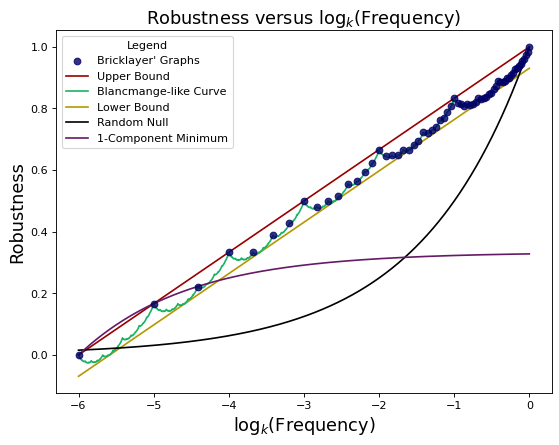

In [3]:
 #@title Generate Plot


fig = plt.figure(figsize=(8, 6), dpi=80)


u, = plt.plot(logF_periodic_all,rho_upper,zorder=1,color=(0.6,0,0))
l, = plt.plot(logF_periodic_all,rho_lower,zorder=2,color=(0.7,0.6,0))
interp, = plt.plot(logF_periodic_all,bg_rho_periodic_all,zorder=3,color=(0.1,0.7,0.4))
randnull, = plt.plot(logF_periodic_all,rho_null,zorder=4,color=(0,0,0))
min1comp, = plt.plot(logF_periodic_all,rho_1comp_min,zorder=5,color=(0.4,0.1,0.4))
if exact_bricklayers:
    bgexact = plt.scatter(logF_all,rhobg_all,zorder=6,color=(0,0,0.4,0.8))

plt.xlabel('log$_{k}$(Frequency)',fontsize=16)
plt.ylabel('Robustness',fontsize=16)
plt.title('Robustness versus log$_{k}$(Frequency)',fontsize=16)

if exact_bricklayers:
    plt.legend([bgexact,u,interp,l,randnull,min1comp],['Bricklayer\' Graphs','Upper Bound','Blancmange-like Curve','Lower Bound','Random Null','1-Component Minimum'],loc="upper left",title='Legend')
else:
    plt.legend([u,interp,l,randnull,min1comp],['Upper Bound','Blancmange-like Curve','Lower Bound','Random Null','1-Component Minimum'],loc="upper left",title='Legend')

In [4]:
#@title Download Plotting Data
#@markdown A folder called `robound_data.zip` will be downloaded containing the following files:
#@markdown - `logF_continuous.txt`, which contains the $\log_k(\text{Frequency})$ values for the continuous lines, where the sum of the frequencies normalizes to 1.
#@markdown - `rho_blancmange.txt`, which contains the interpolated robustness values of the maximum robustness curve (the blancmange-like curve) at the resolution specified.
#@markdown - `rho_upper.txt`, which contains the robustness values of the tight upper bound on the maximum robustness curve.
#@markdown - `rho_lower.txt`, which contains the robustness values of the tight lower bound on the maximum robustness curve.
#@markdown - `rho_null.txt`, the random null expectation where $\text{Robustness} = \text{Frequency}$.
#@markdown - `rho_1min_comp.txt`, the minimum robustness of a neutral set containing exactly one component; this is equal to the robustness of a neutral set which is a star graph.

import os
from google.colab import files

os.system('mkdir ./robound_data')
if exact_bricklayers:
    np.savetxt('./robound_data/logF_exact.txt',logF_all,delimiter=",")
    np.savetxt('./robound_data/rhobg_exact.txt',rhobg_all,delimiter=",")

np.savetxt('./robound_data/logF_continuous.txt',logF_periodic_all,delimiter=",")
np.savetxt('./robound_data/rho_upper.txt',rho_upper,delimiter=",")
np.savetxt('./robound_data/rho_lower.txt',rho_lower,delimiter=",")
np.savetxt('./robound_data/rho_blancmange.txt',bg_rho_periodic_all,delimiter=",")
np.savetxt('./robound_data/rho_null.txt',rho_null,delimiter=",")
np.savetxt('./robound_data/rho_1comp_min.txt',rho_1comp_min,delimiter=",")

os.system('zip -r robound_data.zip robound_data')
files.download('robound_data.zip')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>